# Spark session and import ds

In [56]:
##link_dataset: https://www.kaggle.com/datasets/rushikeshdane20/nashik-apartment-price-prediction

from pyspark.sql import SparkSession
from pyspark.sql import functions
spark = SparkSession.builder.appName('pyspark - example join').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=PySparkShell>

In [243]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression as LinearRegressor
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import pandas as pd
import numpy as np
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as Tester
from pyspark.ml.classification import LogisticRegression as LogisticRegressor
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BinaryEvaluator

In [58]:
dname = "project_biglab.csv"
datapath = os.path.join("/Users/matteofercia/Desktop/datascience/lab_bigdata/project")

In [59]:
df = spark.read.csv(os.path.join(datapath,dname), header=True, inferSchema=True)

# Class definition

In [248]:
class Data_set(object):
    
    def __init__(self,data):
        self.data = data
        
    def split_data(self, dataset, target):
        features = [ x for x in dataset.columns ]
        features.remove(target)
        assembler= VectorAssembler(inputCols=features, outputCol="features")
        assembled = assembler.transform(self.data)
        final_data = assembled.select("features",target)
        training_set, test_set = final_data.randomSplit([0.8,0.2], seed=0)
        return training_set, test_set
        
    def linear_regression(self, target):
        training_set, test_set = self.split_data(self.data, target)
        regressor = LinearRegressor(featuresCol='features', labelCol=target,predictionCol='prediction')
        model = regressor.fit(training_set)
        test_data = test_set.select('features')
        training_data = training_set.select('features')
        predictions_training = model.transform(training_data)
        predictions_test = model.transform(test_data)
        training_result = model.evaluate(training_set)
        test_result = model.evaluate(test_set)
        price_target = test_set.select(target)
        price_points = [ item for item in price_target.collect()]
        performance = model.evaluate(test_set)
        prediction = performance.predictions.select('prediction')
        pred_points = [ item for item in prediction.collect() ]
        
        return ('Training set results:',('RMSE:{}'.format(training_result.rootMeanSquaredError)),('MSE:{}'.format(training_result.meanSquaredError)),
                ('R2:{}'.format(model.summary.r2)),'-----------------------------',
               'Test set results:',('RMSE:{}'.format(test_result.rootMeanSquaredError)),
                ('MSE:{}'.format(test_result.meanSquaredError)),
                ('R2:{}'.format(test_result.r2))), plt.scatter(price_points, pred_points)
    
    def clustering(self, n_cluster):
        assembler = VectorAssembler(inputCols=self.data.columns, outputCol='features')
        output = assembler.transform(self.data)
        scaler = StandardScaler(inputCol='features',outputCol='scaled', withStd=True,withMean=False)
        model = scaler.fit(output)
        output = model.transform(output)
        kmeans = KMeans(featuresCol='scaled', k=n_cluster)
        model = kmeans.fit(output)
        predictions = model.transform(output)
        tester = ClusteringEvaluator()
        silhouette = tester.evaluate(predictions)
        centers = model.clusterCenters()
        return silhouette
    
    def clustering2(self, n1, n2):
        assembler = VectorAssembler(inputCols=self.data.columns, outputCol='features')
        output = assembler.transform(self.data)
        scaler = StandardScaler(inputCol='features',outputCol='scaled', withStd=True,withMean=False)
        model = scaler.fit(output)
        output = model.transform(output)
        tester = ClusteringEvaluator()
        summary = []
        for n in range(n1,n2):
            kmeans = KMeans(featuresCol='scaled', k=n)
            model = kmeans.fit(output)
            predictions = model.transform(output)
            silhouette = tester.evaluate(predictions)
            summary += [ silhouette ]
            print(f"Num of clusters: {n} -- Silhouette with euclidean distance: {silhouette}")
        print(summary)
        return plt.plot(range(n1,n2) ,summary)  
    
    def rf(self, target, maxDepth=5, numTrees=20):
        indexed = StringIndexer(inputCol=target, outputCol="target").fit(self.data).transform(self.data)
        indexed = indexed.drop(target)
        assembler = VectorAssembler(inputCols = indexed.columns[:-1], outputCol = "features")
        assembled = assembler.transform(indexed)
        selected = assembled.select('features','target')
        training_set, test_set = selected.randomSplit([0.8,0.2], seed=0)
        classifier = RF(maxDepth=5,numTrees=20,labelCol="target")
        model = classifier.fit(training_set)
        print(f"Feature Importance:{model.featureImportances}")
        predictions = model.transform(test_set)
        tester = Tester(predictionCol='prediction', labelCol='target')
        accuracy = tester.evaluate(predictions)
        return print(f"Final accuracy is: {accuracy:5.4f}")
        
    def reg_log(self, target):
        indexed = StringIndexer(inputCol=target, outputCol="target").fit(self.data).transform(self.data)
        indexed = indexed.drop(target)
        assembler = VectorAssembler(inputCols = indexed.columns[:-1], outputCol = "features")
        assembled = assembler.transform(indexed)
        scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
        model = scaler.fit(assembled)
        scaled = model.transform(assembled).select('scaled_features','target')
        scaled = scaled.withColumnRenamed('scaled_features','features')
        training_set, test_set = scaled.randomSplit([0.7,0.3], seed=0)
        regressor = LogisticRegressor(featuresCol="features",labelCol='target')
        model = regressor.fit(training_set)
        performance = model.evaluate(test_set)
        predictions = performance.predictions.select('target','prediction')
        evaluator = BinaryEvaluator(rawPredictionCol='prediction', labelCol='target')
        accuracy = evaluator.evaluate(predictions)
        return print(f"Accuracy: {accuracy}")
        

# Linear regression

In [ ]:
df2 = df.alias('df2')
df2 = df2.drop('_c0','address','latitude','longitude','owners')
df2 = df2.where("total_sqft<25000")
df2 = df2.where("per_month_emi<300")
df2 = df2.na.drop()
df2 = df2.where("price<150") #cutting oper month emi over 300

In [60]:
indexed = StringIndexer(inputCol="cordinates", outputCol="cordinates_x", ).fit(df2).transform(df2)
indexed = StringIndexer(inputCol="house_condition", outputCol="house_condition_x").fit(indexed).transform(indexed)
indexed = StringIndexer(inputCol="housetype", outputCol="housetype_x").fit(indexed).transform(indexed)

In [61]:
indexed = indexed.drop("owners","housetype","house_condition","cordinates","cordinates_x")

In [62]:
indexed.printSchema()

root
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)
 |-- house_condition_x: double (nullable = false)
 |-- housetype_x: double (nullable = false)



In [112]:
analisi = Data_set(indexed)

22/04/22 09:38:59 WARN Instrumentation: [1ae3ecd9] regParam is zero, which might cause numerical instability and overfitting.


(('Training set results:',
  'RMSE:6.937765963946868',
  'MSE:48.132596570499615',
  'R2:0.9107088603043545',
  '-----------------------------',
  'Test set results:',
  'RMSE:7.044651043806006',
  'MSE:49.627108328997046',
  'R2:0.9132138990781951'),
 <matplotlib.collections.PathCollection at 0x11a667310>)

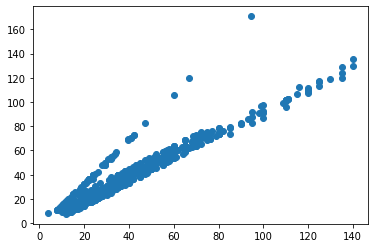

In [113]:
analisi.linear_regression('price')

# Clustering

In [197]:
df3 = df.alias('df3')
df3 = df3.where("total_sqft<25000")
df3 = df3.where("per_month_emi<300")
df3 = df3.drop('_c0','address','latitude','longitude','owners','housetype','house_condition','cordinates')
df3 = df3.where("total_sqft<6000")
df3 = df3.na.drop()

In [200]:
analisi_cluster = Data_set(df3)

Num of clusters: 3 -- Silhouette with euclidean distance: 0.6252080690780363
Num of clusters: 4 -- Silhouette with euclidean distance: 0.5991722847638973
Num of clusters: 5 -- Silhouette with euclidean distance: 0.36200952170911493
Num of clusters: 6 -- Silhouette with euclidean distance: 0.41320249981892915
Num of clusters: 7 -- Silhouette with euclidean distance: 0.35445302388614497
Num of clusters: 8 -- Silhouette with euclidean distance: 0.2377083367943641
[0.6252080690780363, 0.5991722847638973, 0.36200952170911493, 0.41320249981892915, 0.35445302388614497, 0.2377083367943641]


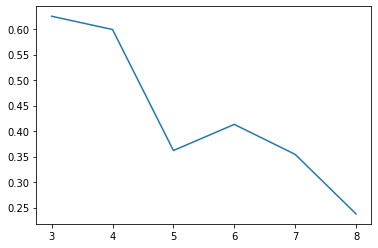

In [202]:
analisi_cluster.clustering2(3,9)

# Classification

## RF

In [238]:
df4 = df2.alias('df4')
df4 = df4.drop('housetype','cordinates')

In [239]:
analisi = Data_set(df4)

In [241]:
analisi.rf('house_condition',6,30)

Feature Importance:(4,[0,1,2,3],[0.0753126040674132,0.5325516196198363,0.23941771192300476,0.15271806438974578])
Final accuracy is: 0.6402


## Logistic regression

In [249]:
analisi = Data_set(df4)

In [250]:
analisi.reg_log('house_condition')

Accuracy: 0.5960999184582646
